In [4]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
from tensorflow import keras
import pathlib
print(tf.config.list_physical_devices('CPU'))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [5]:
data_dir = pathlib.Path('datasets/images_center_10')

In [6]:
batch_size = 32
img_height = 20
img_width = 20

In [7]:
with tf.device('/device:CPU:0'):
  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 5804 files belonging to 2 classes.
Using 4644 files for training.


In [8]:
class_names = train_ds.class_names
print(class_names)

['negative', 'positive']


In [9]:
with tf.device('/device:CPU:0'):
  val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 5804 files belonging to 2 classes.
Using 1160 files for validation.


In [10]:
with tf.device('/device:CPU:0'):
  for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 20, 20, 3)
(32,)


In [11]:
with tf.device('/device:CPU:0'):
  AUTOTUNE = tf.data.AUTOTUNE

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
num_classes = 2
with tf.device('/device:CPU:0'):
  model = keras.Sequential([
  keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Dropout(0.2),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(num_classes)
  ])

In [13]:
with tf.device('/device:CPU:0'):
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [25]:
with tf.device('/device:CPU:0'):
  model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 20, 20, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 20, 20, 16)        448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 10, 10, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 10, 10, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 5, 5, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 5, 5, 64)         

In [10]:
model.load_weights('model_weights/checkpoint_center_unbalanced_10k')

In [26]:
epochs=40
with tf.device('/device:CPU:0'):
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

Epoch 1/40
146/146 [==============================] - 1s 5ms/step - loss: 0.1251 - accuracy: 0.9582 - val_loss: 0.0384 - val_accuracy: 0.9905
Epoch 2/40
146/146 [==============================] - 0s 3ms/step - loss: 0.0329 - accuracy: 0.9912 - val_loss: 0.0245 - val_accuracy: 0.9922
Epoch 3/40
146/146 [==============================] - 0s 3ms/step - loss: 0.0270 - accuracy: 0.9925 - val_loss: 0.0233 - val_accuracy: 0.9957
Epoch 4/40
146/146 [==============================] - 0s 3ms/step - loss: 0.0220 - accuracy: 0.9942 - val_loss: 0.0249 - val_accuracy: 0.9905
Epoch 5/40
146/146 [==============================] - 0s 3ms/step - loss: 0.0178 - accuracy: 0.9953 - val_loss: 0.0138 - val_accuracy: 0.9974
Epoch 6/40
146/146 [==============================] - 0s 3ms/step - loss: 0.0175 - accuracy: 0.9955 - val_loss: 0.0141 - val_accuracy: 0.9974
Epoch 7/40
146/146 [==============================] - 0s 3ms/step - loss: 0.0155 - accuracy: 0.9963 - val_loss: 0.0120 - val_accuracy: 0.9983
Epoch 

In [14]:
model.save_weights('model_weights/checkpoint_center_unbalanced_10k')

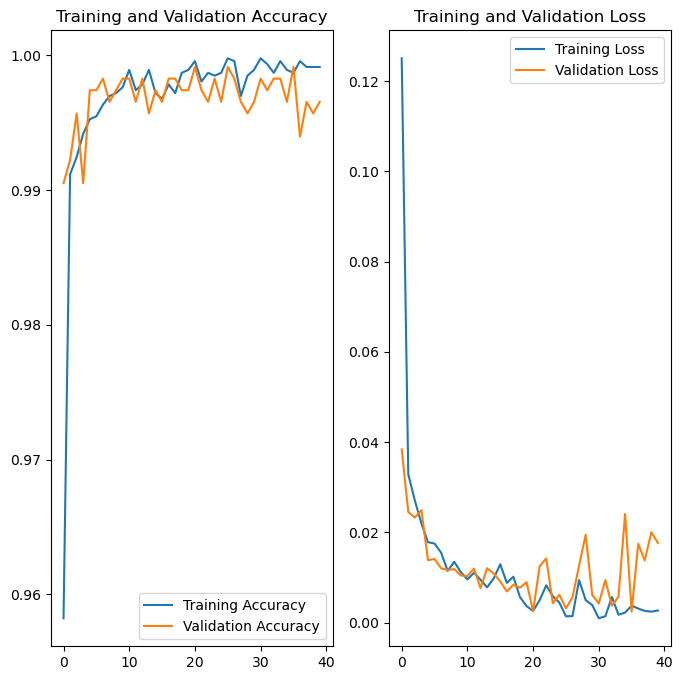

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
path = pathlib.Path('images/minus_minus/3_15642232_17642232.png')
img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

with tf.device('/device:CPU:0'):
  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score))
  )

In [23]:
data_dir = pathlib.Path('test_images')

with tf.device('/device:CPU:0'):
  test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 172597 files belonging to 1 classes.


In [28]:
with open('data/detected_rearengements_v8.csv', mode='w') as output:
  output.write("chr,start,end\n")
  for path in os.listdir('datasets/test_images_center_10/unknown'):
      img_path = os.path.join('datasets/test_images_center_10/unknown', path)
      with tf.device('/device:CPU:0'):
        img = tf.keras.utils.load_img(
            img_path, target_size=(img_height, img_width)
        )
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions = model(img_array)
        score = tf.nn.softmax(predictions[0])

        if np.argmax(score) == 1:
          path_splited = path.split('_')
          coords = (int(path_splited[1]), int(path_splited[2].split('.')[0]))
          output.write(f"X,{path_splited[1]},{path_splited[2].split('.')[0]}\n")
        #else:
          #os.remove(img_path)

C:\Users\vit\AppData\Local\Temp\ipykernel_3452\2421456257.py:10: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(mat_balanced), cmap='Greens')


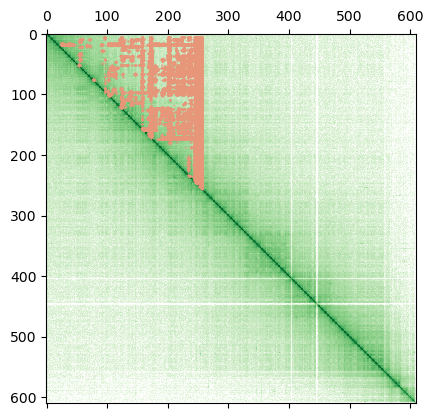

In [16]:
import cooler
import pandas as pd

resolution = 100000
chr = 'X'
c = cooler.Cooler(f'data/ZANU_clean_4DN.mcool::/resolutions/{resolution}')
mat_balanced = c.matrix(balance=False).fetch(chr)
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.matshow(np.log10(mat_balanced), cmap='Greens')

trans = pd.read_csv('data/detected_rearengements_v4.csv')
trans = trans[trans.chr == chr]
trans['start_res'] = trans.start // resolution
trans['end_res'] = trans.end // resolution
plt.scatter(trans.start_res, trans.end_res,s=0.1, c='#E9967A')

plt.savefig('trans.png', dpi=1000)